In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

AMZN = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Nims - DL/Assignment3/AMZN_YTD.csv', index_col='Date', parse_dates=['Date'])
AFRM = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Nims - DL/Assignment3/AFRM_YTD.csv')

AMZN['Open'] = AMZN['Open'].str.replace('$', '', regex=False)
AMZN['High'] = AMZN['High'].str.replace('$', '', regex=False)
AMZN['Low'] = AMZN['Low'].str.replace('$', '', regex=False)
AMZN['Close/Last'] = AMZN['Close/Last'].str.replace('$', '', regex=False)

AMZN['Open'] = pd.to_numeric(AMZN['Open'])
AMZN['High'] = pd.to_numeric(AMZN['High'])
AMZN['Low'] = pd.to_numeric(AMZN['Low'])
AMZN['Close/Last'] = pd.to_numeric(AMZN['Close/Last'])
AMZN['Vol'] = pd.to_numeric(AMZN['Vol'])



print(AMZN.head())
print("\n")
print(AFRM.head())

<ipython-input-7-b0f20cb3677a>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  AMZN = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Nims - DL/Assignment3/AMZN_YTD.csv', index_col='Date', parse_dates=['Date'])


            Close/Last       Vol    Open    High     Low
Date                                                    
2024-12-06      227.03  44.17807  220.75  227.15  220.60
2024-12-05      220.55  41.14022  218.03  222.15  217.30
2024-12-04      218.16  48.74572  215.96  220.00  215.75
2024-12-03      213.44  32.21483  210.31  214.02  209.65
2024-12-02      210.71  39.52319  209.96  212.99  209.51


      Date  Price   Open   High    Low    Vol
0  6/12/24  71.88  69.48  72.28  68.51   6.50
1  5/12/24  68.35  72.48  72.82  68.27   9.03
2  4/12/24  72.00  71.00  72.19  69.85   6.18
3  3/12/24  70.76  67.74  71.77  67.33   8.16
4  2/12/24  68.39  71.89  72.10  67.32  12.15


2/2 [==============================] - 0s 3ms/step


<ipython-input-24-0bf91d525625>:65: RuntimeWarning: divide by zero encountered in divide
  accuracy = 1 - np.mean(np.abs((y_test - predictions[name]) / y_test))


2/2 [==============================] - 0s 4ms/step


<ipython-input-24-0bf91d525625>:65: RuntimeWarning: divide by zero encountered in divide
  accuracy = 1 - np.mean(np.abs((y_test - predictions[name]) / y_test))


2/2 [==============================] - 0s 4ms/step


<ipython-input-24-0bf91d525625>:65: RuntimeWarning: divide by zero encountered in divide
  accuracy = 1 - np.mean(np.abs((y_test - predictions[name]) / y_test))


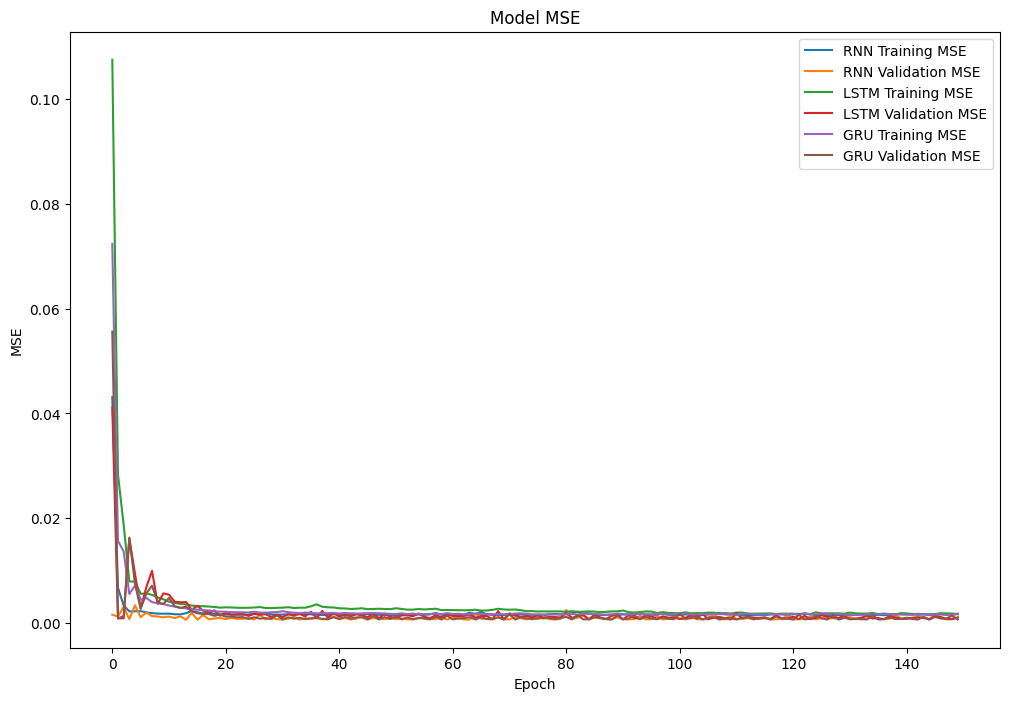

           MSE      RMSE  Accuracy
RNN   0.004832  0.069511      -inf
LSTM  0.005349  0.073139      -inf
GRU   0.003600  0.060004      -inf


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from math import sqrt
from keras.optimizers import Adam

# Load the data
data = AMZN['Close/Last'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 5
X, y = create_sequences(data_scaled, sequence_length)

# Split the data
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Build models
def build_model(model_type):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

models = {'RNN': build_model('RNN'),
          'LSTM': build_model('LSTM'),
          'GRU': build_model('GRU')}

# Train models and collect metrics
history = {}
predictions = {}
metrics = {'MSE': {}, 'RMSE': {}, 'Accuracy': {}}

for name, model in models.items():
    history[name] = model.fit(X_train, y_train, epochs=150, batch_size=32,
                              validation_data=(X_val, y_val), verbose=0)
    predictions[name] = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions[name])
    rmse = sqrt(mse)
    accuracy = 1 - np.mean(np.abs((y_test - predictions[name]) / y_test))

    metrics['MSE'][name] = mse
    metrics['RMSE'][name] = rmse
    metrics['Accuracy'][name] = accuracy

# Plot training, validation, and test MSE
plt.figure(figsize=(12, 8))
for name in models.keys():
    plt.plot(history[name].history['loss'], label=f'{name} Training MSE')
    plt.plot(history[name].history['val_loss'], label=f'{name} Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Print metrics table
AMZN_metrics = pd.DataFrame(metrics)
print(AMZN_metrics)

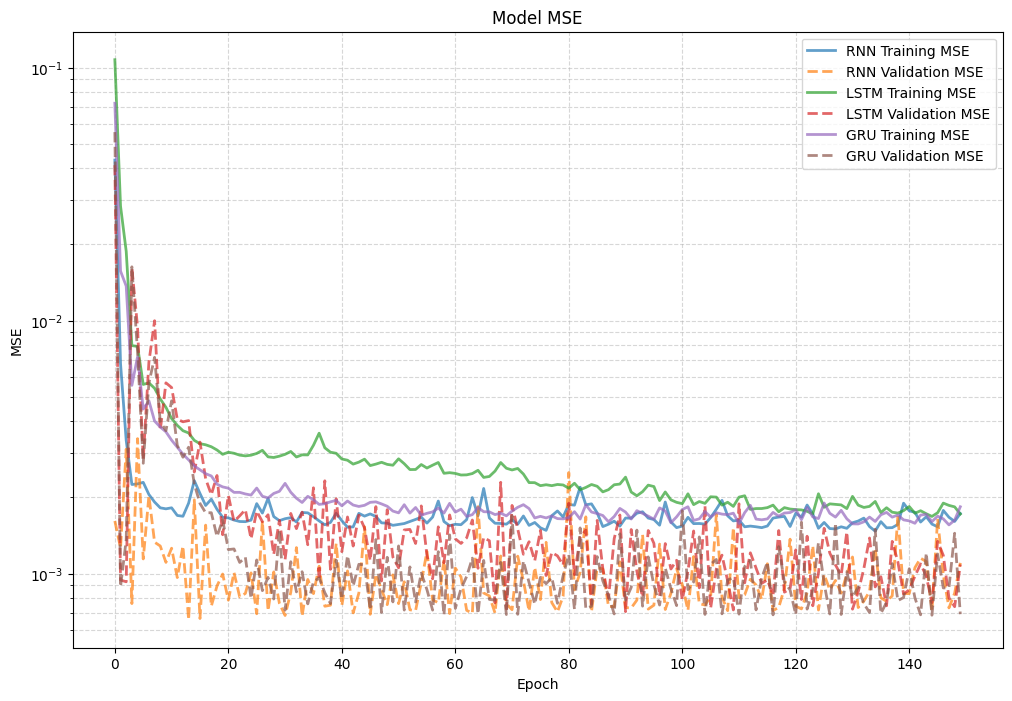

In [26]:
plt.figure(figsize=(12, 8))
for name in models.keys():
    plt.plot(history[name].history['loss'], label=f'{name} Training MSE', linewidth=2, alpha=0.7)
    plt.plot(history[name].history['val_loss'], label=f'{name} Validation MSE', linewidth=2, alpha=0.7, linestyle='--')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

2/2 [==============================] - 0s 3ms/step


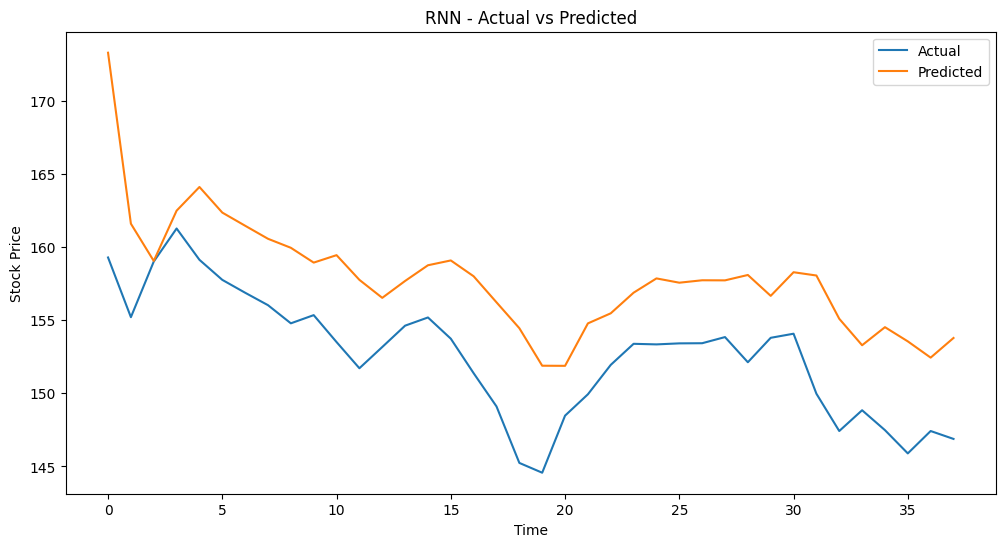

2/2 [==============================] - 0s 4ms/step


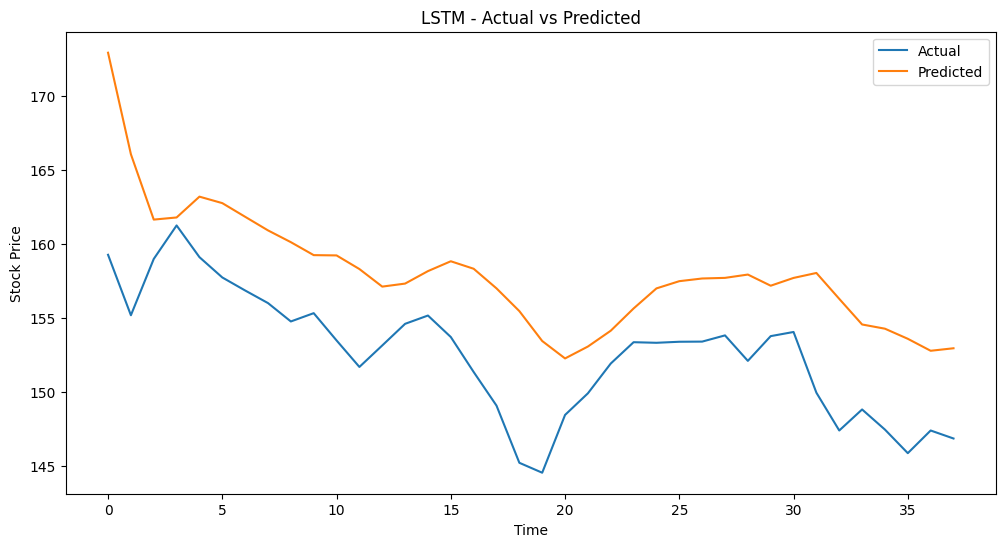

2/2 [==============================] - 0s 4ms/step


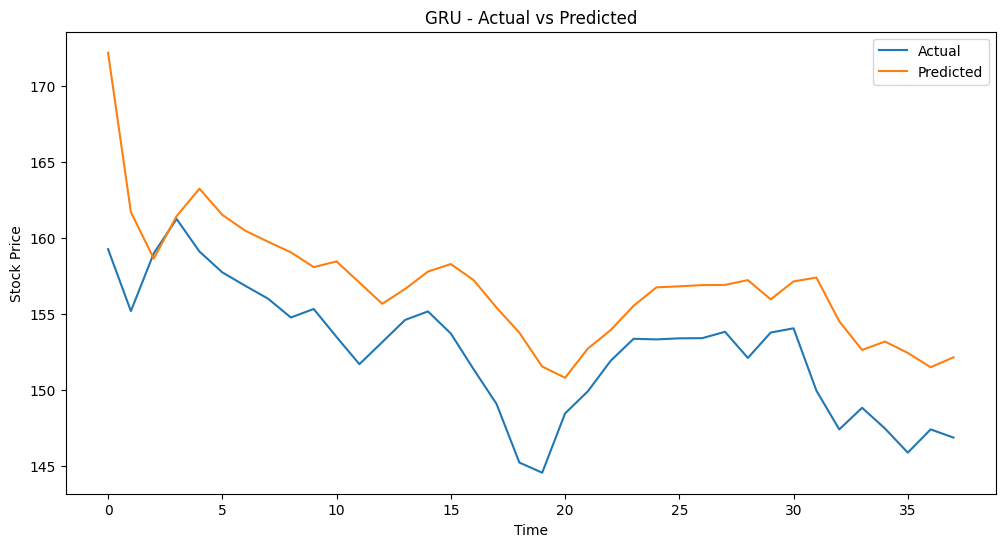

            MSE      RMSE   Accuracy
RNN   32.854390  5.731875  84.210526
LSTM  36.373306  6.031029  78.947368
GRU   24.481864  4.947915  94.736842


In [27]:
def evaluate_models_on_test_set(models, X_test, y_test, scaler):
    results = {}
    for name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test)

        # Inverse transform predictions and actual values
        predictions = scaler.inverse_transform(predictions)
        y_test_inv = scaler.inverse_transform(y_test)

        # Calculate metrics
        mse = mean_squared_error(y_test_inv, predictions)
        rmse = sqrt(mse)
        mae = np.mean(np.abs(y_test_inv - predictions))

        # Calculate accuracy (percentage of predictions within 5% of actual)
        accuracy = np.mean(np.abs((y_test_inv - predictions) / y_test_inv) <= 0.05) * 100

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'Accuracy': accuracy
        }

        # Plot actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_inv, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.title(f'{name} - Actual vs Predicted')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    # Create a DataFrame with the results
    results_df = pd.DataFrame(results).T
    return results_df

# Use the function
test_results = evaluate_models_on_test_set(models, X_test, y_test, scaler)
print(test_results)